In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from catboost import CatBoostRegressor
from tqdm import tqdm
import gc
import datetime as dt

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
properties2016 = pd.read_csv('zillow/properties_2016.csv')
'''properties2017 = pd.read_csv('zillow/properties_2017.csv',error_bad_lines=False)'''

train2016 = pd.read_csv('zillow/train_2016_v2.csv', parse_dates=['transactiondate'])
'''train2017 = pd.read_csv('zillow/train_2017.csv', parse_dates=['transactiondate'])'''

def add_date_features(df):
    df["transaction_year"] = df["transactiondate"].dt.year
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month
    df["transaction_day"] = df["transactiondate"].dt.day
    df["transaction_quarter"] = (df["transactiondate"].dt.year - 2016)*4 +df["transactiondate"].dt.quarter
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

train2016 = add_date_features(train2016)
'''train2017 = add_date_features(train2017)'''

sample_submission = pd.read_csv('zillow/sample_submission.csv')

train2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')
'''train2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')'''


train_df = train2016
test_df = pd.merge(sample_submission[['ParcelId']], properties2016.rename(columns = {'parcelid': 'ParcelId'}), how = 'left', on = 'ParcelId')

del properties2016, train2016
gc.collect();


/home/kai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,logerror,transaction_year,transaction_month,transaction_day,transaction_quarter,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.0276,2016,1,1,1,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,2.0,34280990.0,-118488536.0,7528.0,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.1684,2016,1,1,1,3.5,4.0,7.0,3.5,2263.0,2263.0,6059.0,3.0,2.0,33668120.0,-117677556.0,3643.0,1,261.0,NaN,6.059052e+07,32380.0,1286.0,96962.0,0.0,1.0,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.037615e+13
2,12098116,-0.0040,2016,1,1,1,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,2.0,34136312.0,-118175032.0,11423.0,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.0218,2016,1,2,1,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,2.0,33755800.0,-118309000.0,70859.0,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.0050,2016,1,2,1,2.5,4.0,7.0,2.5,2283.0,2283.0,6059.0,2.0,2.0,33485643.0,-117700234.0,6000.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,96961.0,8.0,1.0,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [3]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].ix[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].ix[train_df['logerror']<llimit] = llimit

'''ulimit_17 = np.percentile(train_df_17.logerror.values, 99)
llimit_17 = np.percentile(train_df_17.logerror.values, 1)
train_df_17['logerror'].ix[train_df_17['logerror']>ulimit_17] = ulimit_17
train_df_17['logerror'].ix[train_df_17['logerror']<llimit_17] = llimit_17'''

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


"ulimit_17 = np.percentile(train_df_17.logerror.values, 99)\nllimit_17 = np.percentile(train_df_17.logerror.values, 1)\ntrain_df_17['logerror'].ix[train_df_17['logerror']>ulimit_17] = ulimit_17\ntrain_df_17['logerror'].ix[train_df_17['logerror']<llimit_17] = llimit_17"

/home/kai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_df = train_df[[c for c in train_df if train_df[c].isnull().sum() < train_df.shape[0]/2]]

In [5]:
train_df.head()

,parcelid,logerror,transaction_year,transaction_month,transaction_day,transaction_quarter,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.0276,2016,1,1,1,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,2.0,34280990.0,-118488536.0,7528.0,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.1684,2016,1,1,1,3.5,4.0,NaN,3.5,2263.0,2263.0,6059.0,3.0,NaN,33668120.0,-117677556.0,3643.0,1,261.0,NaN,6.059052e+07,32380.0,1286.0,96962.0,0.0,NaN,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,12098116,-0.0040,2016,1,1,1,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,2.0,34136312.0,-118175032.0,11423.0,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.0218,2016,1,2,1,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,2.0,33755800.0,-118309000.0,70859.0,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.0050,2016,1,2,1,2.5,4.0,NaN,2.5,2283.0,2283.0,6059.0,2.0,NaN,33485643.0,-117700234.0,6000.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,96961.0,8.0,NaN,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [6]:
mean_values = train_df.median(axis=0)
train_df = train_df.fillna(mean_values, inplace=True)

'''mean_values_17 = train_df_17.median(axis=0)
train_df_17 = train_df_17.fillna(mean_values, inplace=True)'''

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
corr_df

/home/kai/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/kai/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,col_labels,corr_values
8,heatingorsystemtypeid,-0.015578
24,taxamount,-0.014768
15,regionidcounty,-0.009844
18,unitcnt,-0.006459
23,landtaxvaluedollarcnt,-0.004146
2,buildingqualitytypeid,-0.002727
12,propertylandusetypeid,-0.002520
16,regionidzip,-0.002485
9,latitude,-0.001831
14,regionidcity,0.002348


In [7]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.01) | (corr_df['corr_values'] < -0.01)]

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [8]:
corr_df_ = pd.DataFrame()
for name in corr_df_sel['col_labels']:
    corr_df_[name] = train_df[name]

corr_df_.head()

,heatingorsystemtypeid,taxamount,rawcensustractandblock,fips,roomcnt,censustractandblock,structuretaxvaluedollarcnt,yearbuilt,bedroomcnt,fullbathcnt,calculatedbathnbr,bathroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12
0,2.0,6735.88,6.037107e+07,6037.0,0.0,6.037107e+13,122754.0,1959.0,3.0,2.0,2.0,2.0,1684.0,1684.0
1,2.0,10153.02,6.059052e+07,6059.0,0.0,6.037615e+13,346458.0,2014.0,4.0,3.0,3.5,3.5,2263.0,2263.0
2,2.0,11484.48,6.037464e+07,6037.0,0.0,6.037464e+13,61994.0,1940.0,2.0,3.0,3.0,3.0,2217.0,2217.0
3,2.0,3048.74,6.037296e+07,6037.0,0.0,6.037296e+13,171518.0,1987.0,2.0,2.0,2.0,2.0,839.0,839.0
4,2.0,5488.96,6.059042e+07,6059.0,8.0,6.059042e+13,169574.0,1981.0,4.0,2.0,2.5,2.5,2283.0,2283.0


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

vifDict = calculate_vif_(corr_df_)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

validVariables, variablesWithMC

(                    variables  vifScore
 6  structuretaxvaluedollarcnt  4.073254
 1                   taxamount  2.802755
 8                  bedroomcnt  2.432387
 7                   yearbuilt  1.578930
 4                     roomcnt  1.498952
 0       heatingorsystemtypeid  1.119863,
                        variables      vifScore
 5            censustractandblock  6.338384e+06
 2         rawcensustractandblock  8.224542e+03
 3                           fips  8.207695e+03
 10             calculatedbathnbr  7.130656e+01
 9                    fullbathcnt  3.978784e+01
 11                   bathroomcnt  2.632516e+01
 12  calculatedfinishedsquarefeet  1.487516e+01
 13          finishedsquarefeet12  1.181418e+01)

In [29]:
valid_df = pd.DataFrame()

for name in validVariables['variables']:
    valid_df[name] = train_df[name]

valid_df.head()

,structuretaxvaluedollarcnt,taxamount,bedroomcnt,yearbuilt,roomcnt,heatingorsystemtypeid
0,122754.0,6735.88,3.0,1959.0,0.0,2.0
1,346458.0,10153.02,4.0,2014.0,0.0,2.0
2,61994.0,11484.48,2.0,1940.0,0.0,2.0
3,171518.0,3048.74,2.0,1987.0,0.0,2.0
4,169574.0,5488.96,4.0,1981.0,8.0,2.0


In [31]:
fe1 = []
for f in valid_df:
    fe1.append(f)
    
fe1.append('parcelid')
fe1.append('transaction_year')
fe1.append('transaction_month')
fe1.append('transaction_day')
fe1.append('transaction_quarter')

fe1

['structuretaxvaluedollarcnt',
 'taxamount',
 'bedroomcnt',
 'yearbuilt',
 'roomcnt',
 'heatingorsystemtypeid',
 'parcelid',
 'transaction_year',
 'transaction_month',
 'transaction_day',
 'transaction_quarter']

In [32]:
X_train = train_df[fe1]
y_train = train_df['logerror']
X_train = X_train.rename(columns = {'parcelid': 'ParcelId'})
y_train = y_train.rename(columns = {'parcelid': 'ParcelId'})
X_train.head()

,structuretaxvaluedollarcnt,taxamount,bedroomcnt,yearbuilt,roomcnt,heatingorsystemtypeid,ParcelId,transaction_year,transaction_month,transaction_day,transaction_quarter
0,122754.0,6735.88,3.0,1959.0,0.0,2.0,11016594,2016,1,1,1
1,346458.0,10153.02,4.0,2014.0,0.0,2.0,14366692,2016,1,1,1
2,61994.0,11484.48,2.0,1940.0,0.0,2.0,12098116,2016,1,1,1
3,171518.0,3048.74,2.0,1987.0,0.0,2.0,12643413,2016,1,2,1
4,169574.0,5488.96,4.0,1981.0,8.0,2.0,14432541,2016,1,2,1


In [33]:
fe = []
for f in X_train:
    fe.append(f)
    
fe

['structuretaxvaluedollarcnt',
 'taxamount',
 'bedroomcnt',
 'yearbuilt',
 'roomcnt',
 'heatingorsystemtypeid',
 'ParcelId',
 'transaction_year',
 'transaction_month',
 'transaction_day',
 'transaction_quarter']

In [35]:
test_df['transactiondate'] = pd.Timestamp('2016-12-01') 
test_df = add_date_features(test_df)
X_test = test_df[fe]

X_test.head()

,structuretaxvaluedollarcnt,taxamount,bedroomcnt,yearbuilt,roomcnt,heatingorsystemtypeid,ParcelId,transaction_year,transaction_month,transaction_day,transaction_quarter
0,NaN,NaN,0.0,NaN,0.0,NaN,10754147,2016,12,1,4
1,NaN,NaN,0.0,NaN,0.0,NaN,10759547,2016,12,1,4
2,650756.0,20800.37,0.0,NaN,0.0,NaN,10843547,2016,12,1,4
3,571346.0,14557.57,0.0,1948.0,0.0,NaN,10859147,2016,12,1,4
4,193796.0,5725.17,0.0,1947.0,0.0,NaN,10879947,2016,12,1,4


In [36]:
test_dates = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']
test_columns = ['201610','201611','201612','201710','201711','201712']


In [37]:
X_train.shape, y_train.shape

((90275, 11), (90275,))

In [ ]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, y_train)

In [29]:
for i in range(len(test_dates)):
    X_test['transactiondate'] = test_dates[i]
    X_test = add_date_features()
    pred = model.predict(X_test)
    submission[test_columns[i]] = [float(format(x, '.4f')) for x in pred]

(                    variables  vifScore
 6  structuretaxvaluedollarcnt  4.080840
 0                   taxamount  2.804325
 8                  bedroomcnt  2.423140
 7                   yearbuilt  1.567932
 4                     roomcnt  1.507934
 1       heatingorsystemtypeid  1.163080,
                        variables      vifScore
 5            censustractandblock  8.119157e+06
 2         rawcensustractandblock  8.297037e+03
 3                           fips  8.217661e+03
 10             calculatedbathnbr  6.097598e+01
 9                    fullbathcnt  4.005253e+01
 11                   bathroomcnt  1.899847e+01
 12  calculatedfinishedsquarefeet  1.675381e+01
 13          finishedsquarefeet12  1.385479e+01)

,structuretaxvaluedollarcnt,taxamount,bedroomcnt,yearbuilt,roomcnt,heatingorsystemtypeid
0,122754.0,6735.88,3.0,1959.0,0.0,2.000000
1,346458.0,10153.02,4.0,2014.0,0.0,3.926979
2,61994.0,11484.48,2.0,1940.0,0.0,2.000000
3,171518.0,3048.74,2.0,1987.0,0.0,2.000000
4,169574.0,5488.96,4.0,1981.0,8.0,3.926979


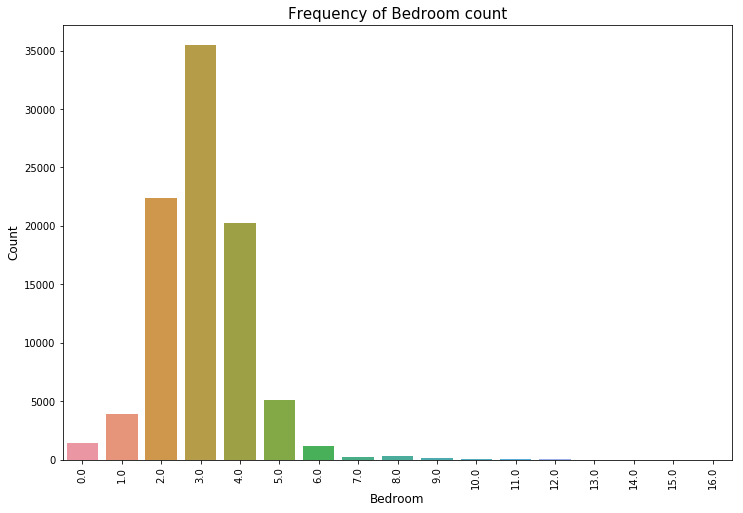